# Newton-Cotes uniform node interpolation.

These are rough notes. If you don't understand what's going on here and you want to understand it, feel free to get in touch and ask me to explain better.

In some time-stepping settings, it's nice to use a uniform grid for discretization since the grid spacing affects stability. For example, the [Courant-Friedrichs-Lewy](https://en.wikipedia.org/wiki/Courant–Friedrichs–Lewy_condition).

There are two experiments here:
1. What happens if we interpolate on a uniform grid and then integrate exactly. This is like the implementation of a normal BIE method since we can adaptively use upsampling to accurately evaluate integrals. 
2. What happens if we interpolate on a uniform grid *and* integrate on that same uniform grid. This is simply a demonstration that Newton-Cotes *alone* would work, though not super well.

In [1]:
import quadpy
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

ncq = []
ps = np.arange(2, 21, 3)
for i in ps:
    ncq.append(quadpy.c1.newton_cotes_open(i))

# Using uniform node interpolation to represent the solution to a BIE.

This first experiment uses a very high order quadrature rule to remove all quadrature error and focus on the error coming from different choices of nodes for interpolating the density. This is most similar to what I am doing in practice. 

running for A=1, C=2


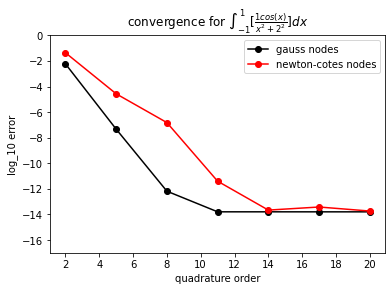

running for A=1, C=1/5


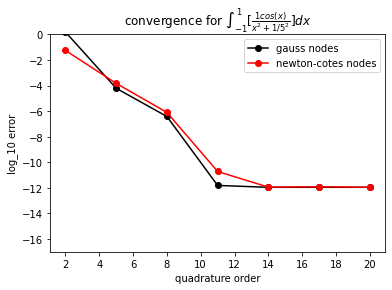

running for A=2, C=2


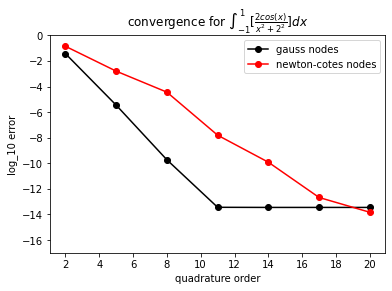

running for A=2, C=1/5


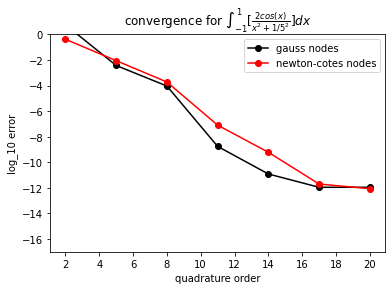

running for A=3, C=2


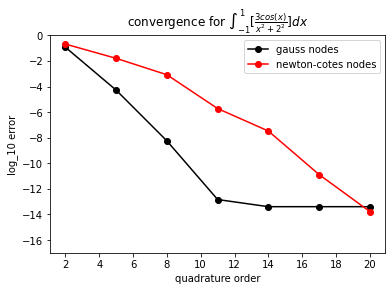

running for A=3, C=1/5


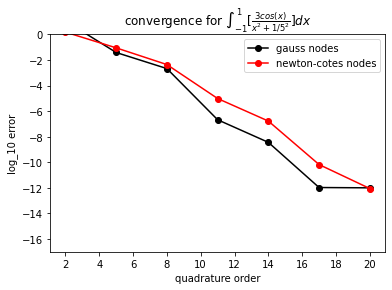

In [5]:
# We use a 1000-th order Gauss rule to examine the case where integrals
# are computed exactly. This will isolate error coming from our
# representation of the density.
gq = quadpy.c1.gauss_legendre(1000)
gqx = gq.points
gqw = gq.weights

spx = sp.var('x')
for A in [1, 2, 3]:
    for C in [2, sp.Rational(1,5)]:
        print(f'running for A={A}, C={C}')

        # The exact density function
        gsp = sp.cos(A * spx)

        # The symbolic kernel
        fsp = 1 / (spx ** 2 + C ** 2)
        g = sp.lambdify((spx,), gsp)
        f = sp.lambdify((spx,), fsp)

        # Integrate symbolically to get the exact value.
        exact = float(sp.integrate(gsp * fsp, (spx, -1, 1)))

        gauss_err = []
        for i in range(ps.shape[0]):
            # Barycentric interpolation at the Gauss nodes
            I = quadpy.c1.gauss_legendre(ps[i])
            Ix = I.points
            Iw = I.weights
            dist = Ix[:, None] - Ix[None, :]
            np.fill_diagonal(dist, 1.0)
            interp_weights = 1.0 / np.prod(dist, axis=1)
            dist = gqx[:,None] - Ix[None,:]
            kernel = interp_weights[None, :] / dist
            interp_g = kernel.dot(g(Ix)) / np.sum(kernel, axis=1)
            
            # Integrate with the density interpolated at the gauss nodes: interp_g
            # and the kernel evaluated at the quadrature nodes
            est = np.sum(interp_g * f(gqx) * gqw)
            gauss_err.append(est - exact)


        nc_err = []
        for i in range(ps.shape[0]):
            # Barycentric interpolation at the Newton-Cotes nodes
            I = ncq[i]
            Ix = I.points
            Iw = I.weights
            dist = Ix[:, None] - Ix[None, :]
            np.fill_diagonal(dist, 1.0)
            interp_weights = 1.0 / np.prod(dist, axis=1)
            dist = gqx[:,None] - Ix[None,:]
            kernel = interp_weights[None, :] / dist
            interp_g = kernel.dot(g(Ix)) / np.sum(kernel, axis=1)

            # Integrate with the density interpolated at the gauss nodes: interp_g
            # and the kernel evaluated at the quadrature nodes
            est = np.sum(interp_g * f(gqx) * gqw)
            nc_err.append(est - exact)

        plt.title(r'convergence for $\int_{-1}^{1}[\frac{' + str(A) + r'cos(x)}{x^2 + ' + str(C) + r'^2}]dx$')
        plt.plot(ps, np.log10(np.abs(gauss_err)), 'k-o', label='gauss nodes')
        plt.plot(ps, np.log10(np.abs(nc_err)), 'r-o', label='newton-cotes nodes')
        plt.xticks(np.arange(2,21,2))
        plt.ylim([-17, 0])
        plt.xlabel('quadrature order')
        plt.ylabel('log_10 error')
        plt.legend()
        plt.show()

# Newton-Cotes vs Gauss for a hypersingular integral

Lets integrate 

$$
\int_{-1}^{1} \frac{1}{x^2 + C^2} dx
$$
for different values of $C$.
    
Looking at the figures below, it's clear that:
1. Newton-Cotes is pretty terrible compared to Gaussian quadrature for small $C$.
2. It's also bad for large $C$. But, not horrible.

In a BIE method, $C$ is controllable by setting the distance at which we refine source panels. If a source panel is in a position such that $C$ would be large, by dividing that source panel in half $C$ will be made approximately twice as large. So, this isn't a disaster for Newton-Cotes.

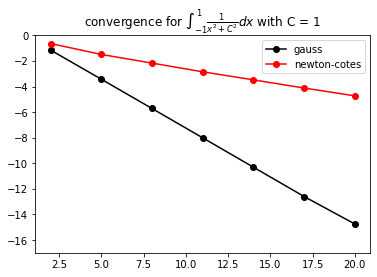

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_79252/408265491.py:24: RuntimeWarning: divide by zero encountered in log10
  plt.plot(ps, np.log10(np.abs(gauss_err)), 'k-o', label='gauss')


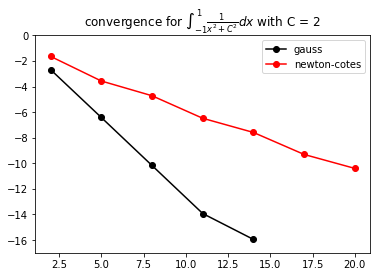

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_79252/408265491.py:24: RuntimeWarning: divide by zero encountered in log10
  plt.plot(ps, np.log10(np.abs(gauss_err)), 'k-o', label='gauss')


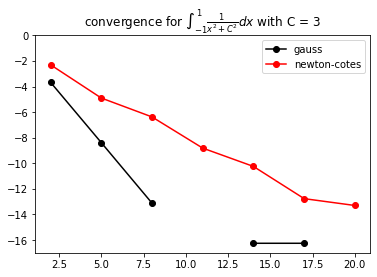

In [9]:
for C in [1, 2, 3]:
    f = lambda x: 1 / (x ** 2 + C ** 2)
    exact = float(sp.integrate(1 / (spx ** 2 + C ** 2), (spx, -1, 1)))
    gauss_err = []
    for i in ps:
        q = quadpy.c1.gauss_legendre(i)
        qx = q.points
        qw = q.weights
        est = np.sum(f(qx) * qw)
        gauss_err.append(est - exact)

    nc_err = []
    for i in range(ps.shape[0]):
        q = ncq[i]
        qx = q.points
        qw = q.weights
        est = np.sum(f(qx) * qw)
        nc_err.append(est - exact)

    plt.title(r'convergence for $\int_{-1}^{1}\frac{1}{x^2 + C^2}dx$ with C = ' + str(C))
    plt.plot(ps, np.log10(np.abs(gauss_err)), 'k-o', label='gauss')
    plt.plot(ps, np.log10(np.abs(nc_err)), 'r-o', label='newton-cotes')
    plt.ylim([-17, 0])
    plt.legend()
    plt.show()